<a href="https://colab.research.google.com/github/Ruthyohanna11/VIX-Kalbe-Nutritionals/blob/main/Kalbe_Ruth_Yohanna_Banjarnahor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

Baca Data

In [2]:
df_customer = pd.read_csv(r'/content/Case Study - Customer.csv', delimiter=';')
df_product = pd.read_csv(r'/content/Case Study - Product.csv', delimiter=';')
df_store = pd.read_csv(r'/content/Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv(r'/content/Case Study - Transaction.csv', delimiter=';')

In [3]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

Data Cleansing

In [4]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [5]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [6]:
df_customer.duplicated().sum()

0

In [7]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [8]:
df_customer[df_customer['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4
415,416,27,1,NaN,"3,43"
442,443,33,1,NaN,"9,28"


In [9]:
df_customer[df_customer['Marital Status'].isnull()].shape

(3, 5)

In [10]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [11]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [12]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [13]:
#Data cleansing df customer
df_customer['Income'] = df_customer['Income'].replace('[,]','.', regex=True).astype('float')

In [14]:
#Data cleansing df store
df_store['Latitude'] = df_store['Latitude'].replace('[,]','.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]','.', regex=True).astype('float')

In [15]:
#Data cleansing df transaction
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [16]:
df_transaction['TransactionID'].value_counts()

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: TransactionID, Length: 4908, dtype: int64

Gabungkan Semua Data

In [17]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [18]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


Model Machine Learning Regresi (Time Series)

In [19]:
#Data Preprocessing
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

In [20]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


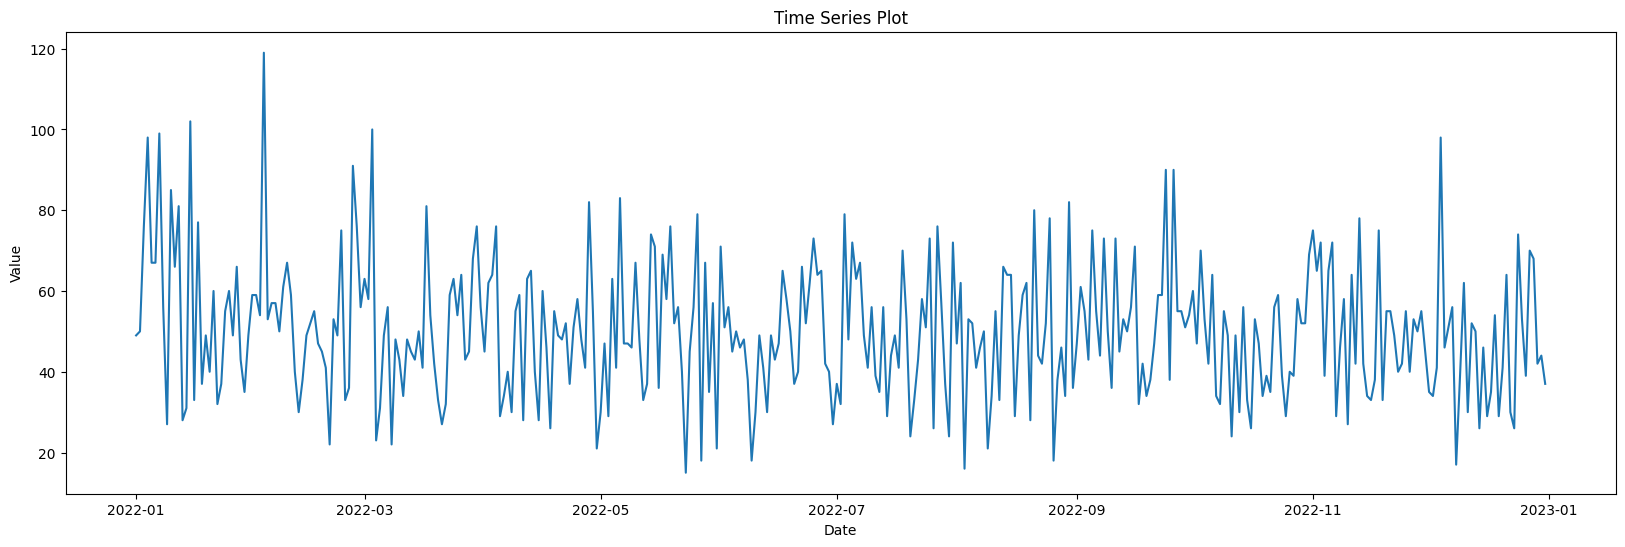

In [21]:
plt.figure(figsize = (20,6))
plt.plot(df_regresi['Date'], df_regresi['Qty'], linestyle = '-')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

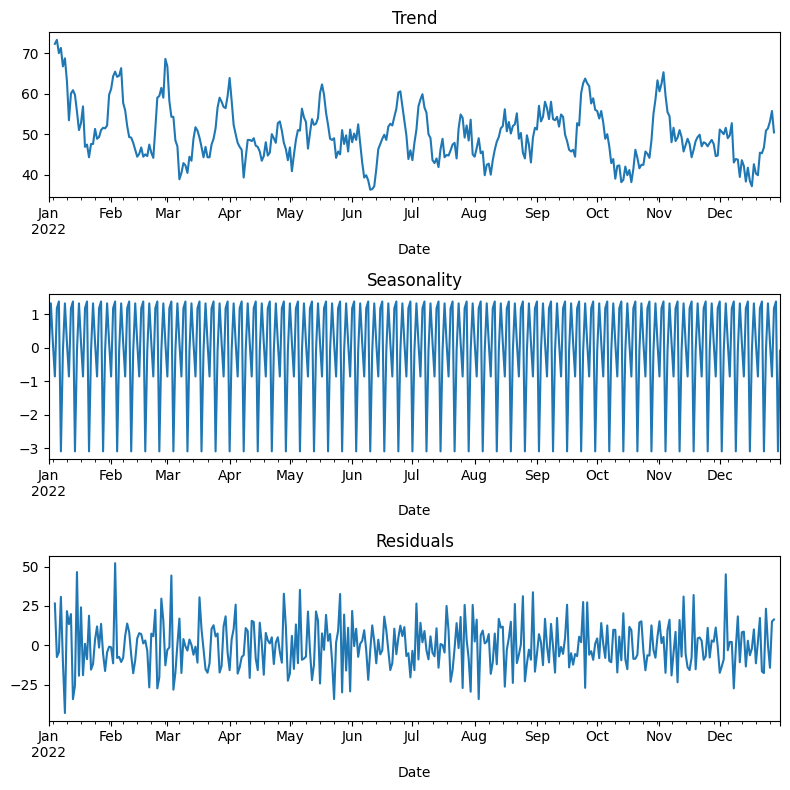

In [22]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(8,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Stationary Data Check

In [23]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_regresi['Qty'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if (result[1]) <= 0.05:
    print('\nReject H0. Data is stationary')
else:
    print('\nAccept H0. Data is not stationary')

ADF Statistic: -19.018783
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571

Reject H0. Data is stationary


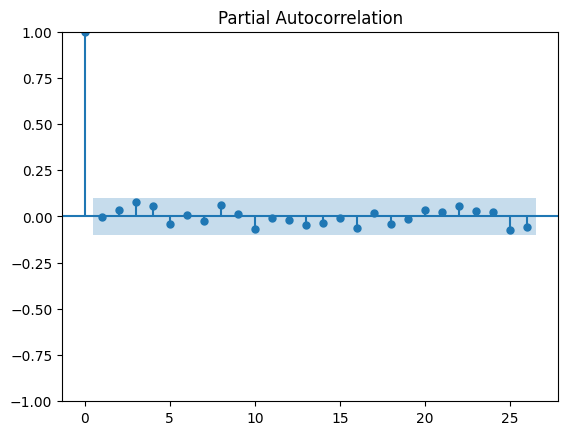

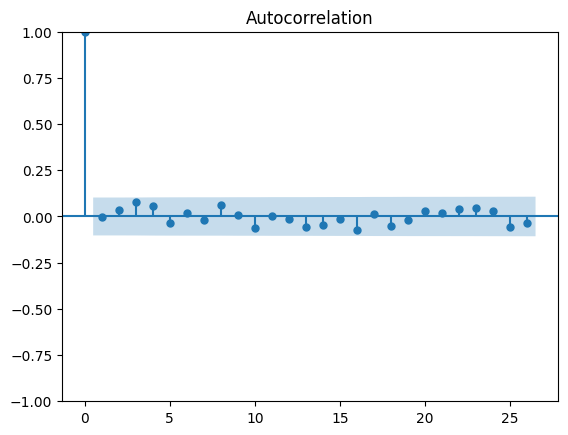

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

original_pacf = plot_pacf(df_regresi['Qty'])
original_acf = plot_acf(df_regresi['Qty'])

Data Splitting and Training

In [25]:
split_size = round(df_regresi.shape[0] * 0.8)
df_train = df_regresi[:split_size]
df_test = df_regresi[split_size:].reset_index(drop=True)
df_train.shape, df_test.shape

((292, 2), (73, 2))

In [26]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47


In [27]:
df_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,44


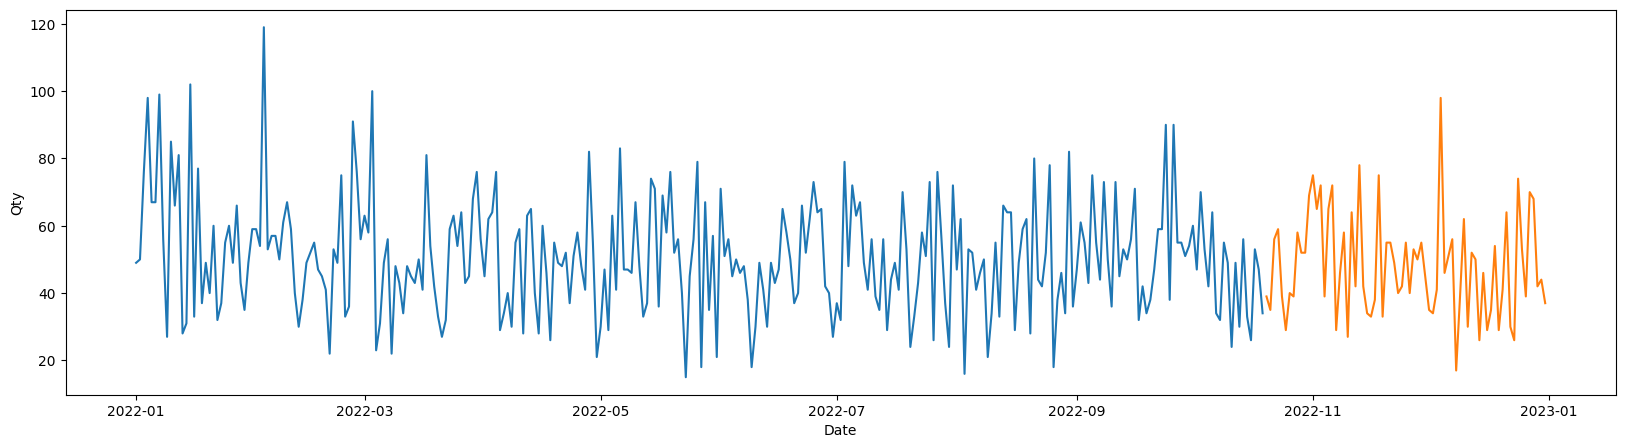

In [28]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty']);
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty']);

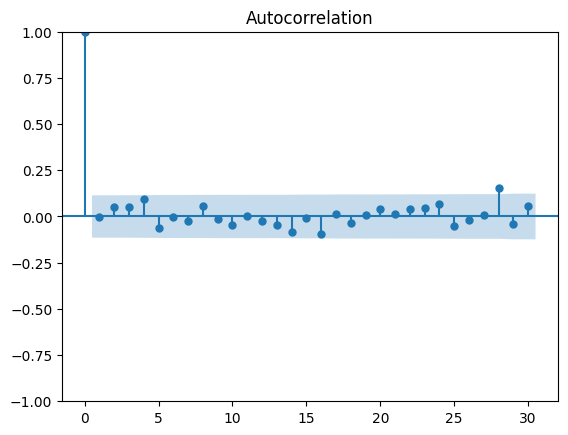

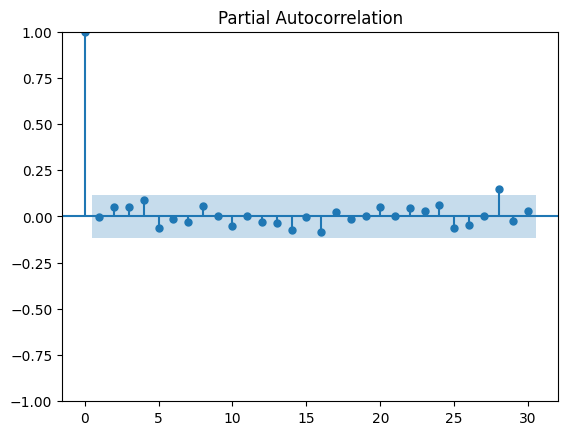

In [29]:
#Model 2: ACF & PACF Plot

train_acf = plot_acf(df_train['Qty'], lags = 30)
train_pacf = plot_pacf(df_train['Qty'], lags = 30)

In [30]:
def rmse (y_actual, y_read):
  #function to calculate RMSE
  print(f'RMSE value {mean_squared_error(y_actual, y_read)**0.5}')

def eval(y_actual, y_pred):
  #function to eval machine learning modelling

  rmse(y_actual, y_pred)
  print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

In [31]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.4 MB/s eta 0:00:00


In [32]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings ("ignore")

#Model 1: Auto Arima
stepwise_fit = auto_arima(df_train['Qty'],trace = True,
                          suppress_warnings = True)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2492.660, Time=1.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2486.299, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2488.299, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2488.299, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3153.727, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2490.294, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.883 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:                        SARIMAX   Log Likelihood               -1241.150
Date:                Sun, 01 Oct 2023   AIC                           2486.299
Time:                        06:26:01   BIC                           2493.653
Sample:                             0   HQIC                          2489.245
          

(0.0, 100.0)

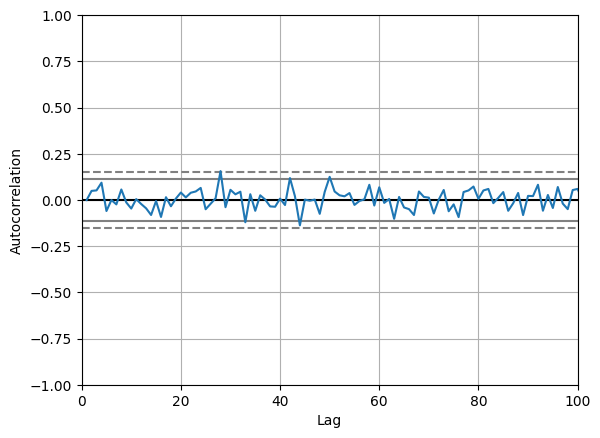

In [33]:
from pandas.plotting import autocorrelation_plot

#Model 3: Pandas Autocorrelation Plot
autocorrelation_plot(df_train['Qty']).set_xlim([0, 100])

In [34]:
from statsmodels.tsa.arima.model import ARIMA

y = df_train['Qty']

model_1 = ARIMA(y, order = (0,0,0))
model_2 = ARIMA(y, order = (28,0,28))
model_3 = ARIMA(y, order = (44,0,44))

In [35]:
model_1 = model_1.fit()
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  292
Model:                          ARIMA   Log Likelihood               -1241.150
Date:                Sun, 01 Oct 2023   AIC                           2486.299
Time:                        06:26:12   BIC                           2493.653
Sample:                             0   HQIC                          2489.245
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.6336      1.060     47.748      0.000      48.555      52.712
sigma2       288.0511     21.937     13.131      0.000     245.056     331.046
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [36]:
print(df_train.head())

        Date  Qty
0 2022-01-01   49
1 2022-01-02   50
2 2022-01-03   76
3 2022-01-04   98
4 2022-01-05   67


In [37]:
model_2 = model_2.fit()
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  292
Model:               ARIMA(28, 0, 28)   Log Likelihood               -1210.274
Date:                Sun, 01 Oct 2023   AIC                           2536.549
Time:                        06:27:07   BIC                           2749.800
Sample:                             0   HQIC                          2621.969
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.6849      3.009     16.842      0.000      44.786      56.583
ar.L1          0.1138      0.494      0.230      0.818      -0.855       1.083
ar.L2          0.3573      0.510      0.701      0.4

In [38]:
print(df_train.head())

        Date  Qty
0 2022-01-01   49
1 2022-01-02   50
2 2022-01-03   76
3 2022-01-04   98
4 2022-01-05   67


In [39]:
model_3 = model_3.fit()
print(model_3.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  292
Model:               ARIMA(44, 0, 44)   Log Likelihood               -1189.734
Date:                Sun, 01 Oct 2023   AIC                           2559.469
Time:                        06:29:24   BIC                           2890.377
Sample:                             0   HQIC                          2692.017
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.6673      1.580     32.061      0.000      47.570      53.765
ar.L1          0.0835      0.507      0.165      0.869      -0.909       1.076
ar.L2          0.1670      0.550      0.304      0.7

In [40]:
print(df_train.head())

        Date  Qty
0 2022-01-01   49
1 2022-01-02   50
2 2022-01-03   76
3 2022-01-04   98
4 2022-01-05   67


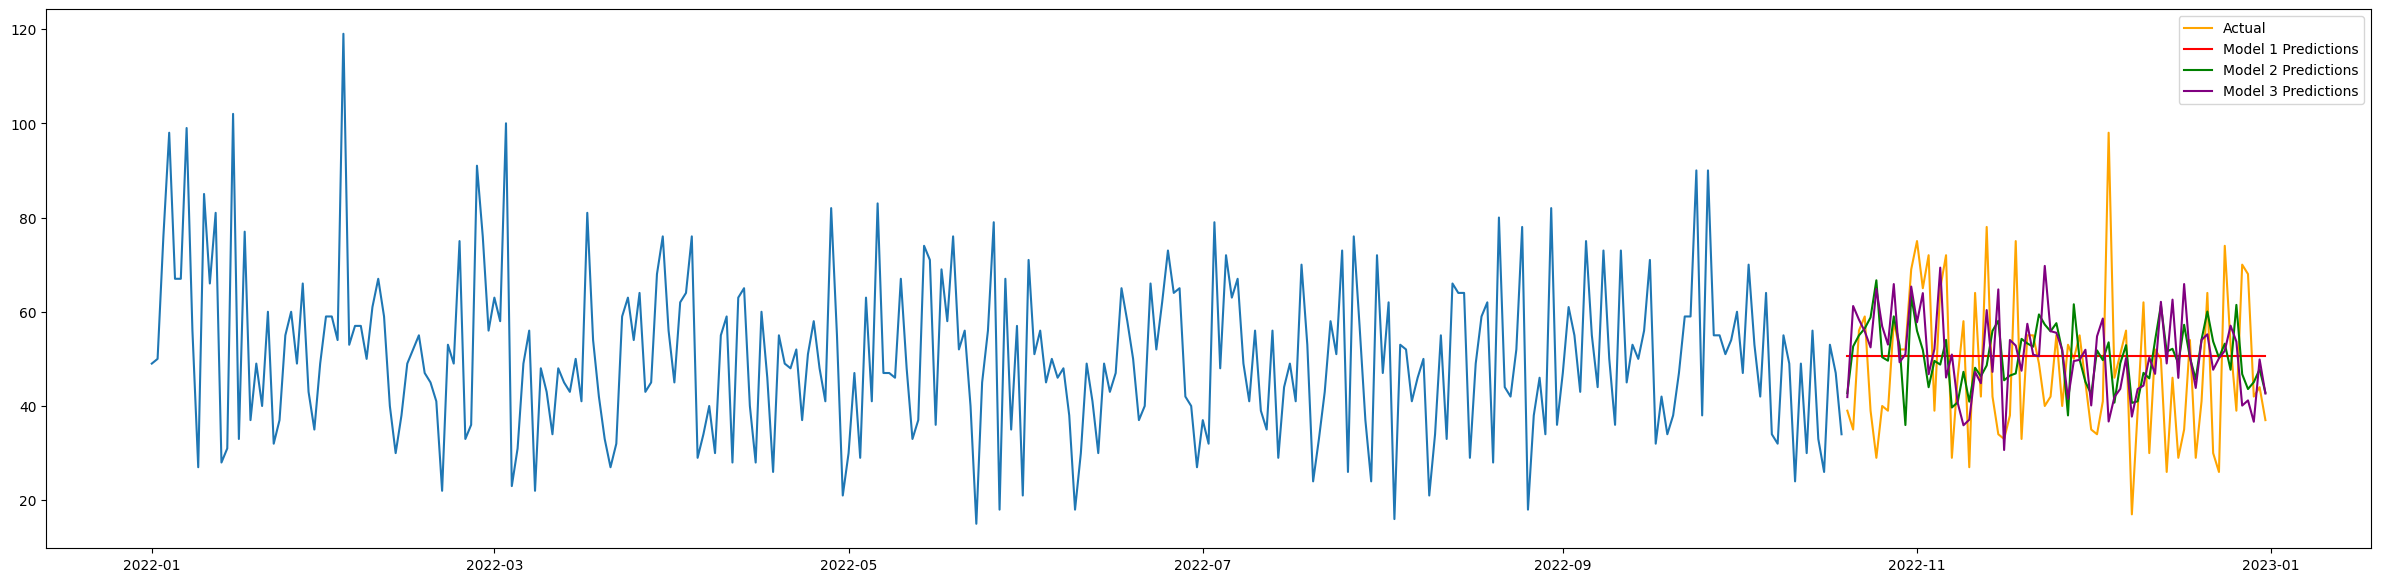

In [41]:
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y_pred_1 = model_1.get_forecast(len(df_test))
y_pred_2 = model_2.get_forecast(len(df_test))
y_pred_3 = model_3.get_forecast(len(df_test))

y_pred_df_1 = y_pred_1.conf_int()
y_pred_df_1['Predictions'] = model_1.predict(start = y_pred_df_1.index[0], end = y_pred_df_1.index[-1])
y_pred_df_1.index = df_test.index
y_pred_out_1 = y_pred_df_1['Predictions']

y_pred_df_2 = y_pred_2.conf_int()
y_pred_df_2['Predictions'] = model_2.predict(start = y_pred_df_2.index[0], end = y_pred_df_2.index[-1])
y_pred_df_2.index = df_test.index
y_pred_out_2 = y_pred_df_2['Predictions']

y_pred_df_3 = y_pred_3.conf_int()
y_pred_df_3['Predictions'] = model_3.predict(start = y_pred_df_3.index[0], end = y_pred_df_3.index[-1])
y_pred_df_3.index = df_test.index
y_pred_out_3 = y_pred_df_3['Predictions']

plt.figure(figsize = (30,7))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color = 'orange', label = 'Actual')
plt.plot(y_pred_out_1, color = 'red', label = 'Model 1 Predictions')
plt.plot(y_pred_out_2, color = 'green', label = 'Model 2 Predictions')
plt.plot(y_pred_out_3, color = 'purple', label = 'Model 3 Predictions')
plt.legend()

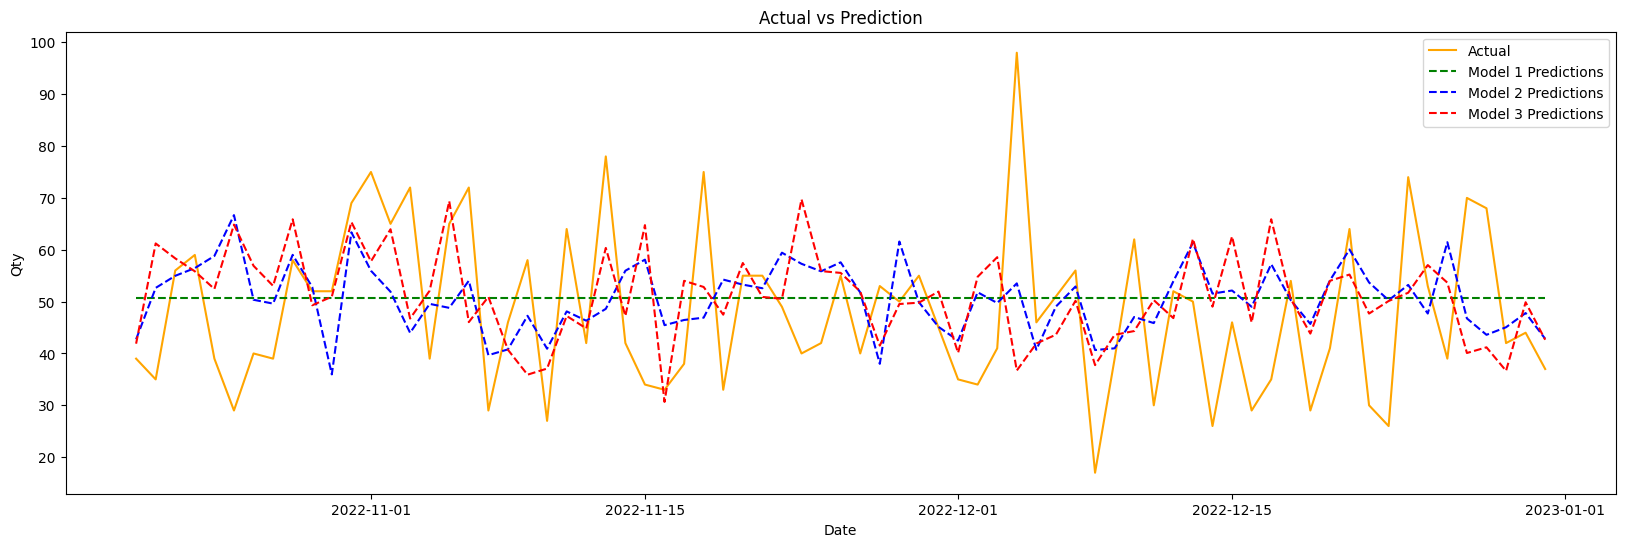

In [42]:
y_actual = df_test['Qty']

plt.figure(figsize=(20, 6))
plt.plot(df_test.index, y_actual, label = 'Actual', color = 'orange')
plt.plot(df_test.index, y_pred_out_1, label= 'Model 1 Predictions', linestyle='--', color = 'green')
plt.plot(df_test.index, y_pred_out_2, label= 'Model 2 Predictions', linestyle='--', color = 'blue')
plt.plot(df_test.index, y_pred_out_3, label= 'Model 3 Predictions', linestyle='--', color = 'red')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.title('Actual vs Prediction')
plt.show()

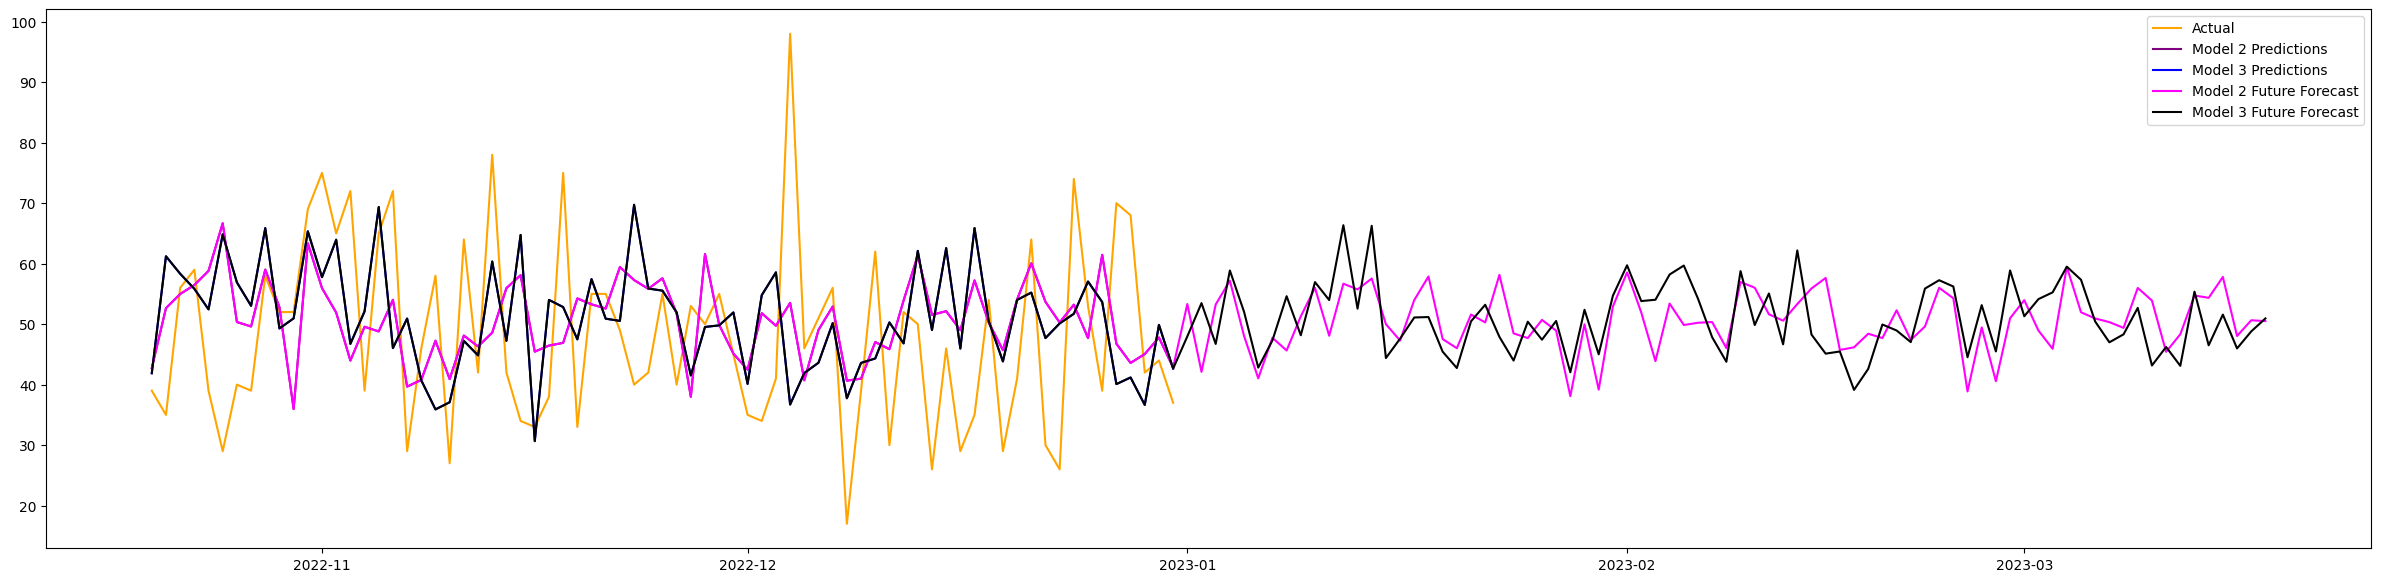

In [43]:
forecast_periods = 150

y_pred_2_future = model_2.get_forecast(steps=forecast_periods)
y_pred_df_2_future = y_pred_2_future.conf_int()
y_pred_df_2_future['Predictions'] = y_pred_2_future.predicted_mean
y_pred_df_2_future.index = pd.date_range(start=df_train.index[-1], periods=forecast_periods+1, closed='right')
y_pred_out_2_future = y_pred_df_2_future['Predictions']

y_pred_3_future = model_3.get_forecast(steps=forecast_periods)
y_pred_df_3_future = y_pred_3_future.conf_int()
y_pred_df_3_future['Predictions'] = y_pred_3_future.predicted_mean
y_pred_df_3_future.index = pd.date_range(start=df_train.index[-1], periods=forecast_periods+1, closed='right')
y_pred_out_3_future = y_pred_df_3_future['Predictions']

plt.figure(figsize=(30, 7))
plt.plot(df_test['Qty'], color='orange', label='Actual')
plt.plot(y_pred_out_2, color='purple', label='Model 2 Predictions')
plt.plot(y_pred_out_3, color='blue', label='Model 3 Predictions')
plt.plot(y_pred_out_2_future, color='magenta', linestyle='-', label='Model 2 Future Forecast')
plt.plot(y_pred_out_3_future, color='black', linestyle='-', label='Model 3 Future Forecast')
plt.legend()

In [44]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae_1 = mean_absolute_error (df_test, y_pred_out_1)
mse_1 = mean_squared_error (df_test, y_pred_out_1)
rmse_1 = np.sqrt (mean_squared_error(df_test, y_pred_out_1))
mape_1 = mean_absolute_percentage_error(df_test, y_pred_out_1)*100

mae_2 = mean_absolute_error (df_test, y_pred_out_2)
mse_2 = mean_squared_error (df_test, y_pred_out_2)
rmse_2 = np.sqrt (mean_squared_error(df_test, y_pred_out_2))
mape_2 = mean_absolute_percentage_error(df_test, y_pred_out_2)*100

mae_3 = mean_absolute_error (df_test, y_pred_out_3)
mse_3 = mean_squared_error (df_test, y_pred_out_3)
rmse_3 = np.sqrt (mean_squared_error(df_test, y_pred_out_3))
mape_3 = mean_absolute_percentage_error(df_test, y_pred_out_3)*100

print("Model 1")
print(f"Mean Absolute Error (MAE): {mae_1:.2f}")
print(f"Mean Squared Error (MSE): {mse_1:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_1:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_1:.2f}%")

print("\nModel 2")
print(f"Mean Absolute Error (MAE): {mae_2:.2f}")
print(f"Mean Squared Error (MSE): {mse_2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_2:.2f}%")

print("\nModel 3")
print(f"Mean Absolute Error (MAE): {mae_3:.2f}")
print(f"Mean Squared Error (MSE): {mse_3:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_3:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_3:.2f}%")

Model 1
Mean Absolute Error (MAE): 12.82
Mean Squared Error (MSE): 240.44
Root Mean Squared Error (RMSE): 15.51
Mean Absolute Percentage Error (MAPE): 31.63%

Model 2
Mean Absolute Error (MAE): 13.00
Mean Squared Error (MSE): 255.51
Root Mean Squared Error (RMSE): 15.98
Mean Absolute Percentage Error (MAPE): 31.30%

Model 3
Mean Absolute Error (MAE): 13.42
Mean Squared Error (MSE): 294.06
Root Mean Squared Error (RMSE): 17.15
Mean Absolute Percentage Error (MAPE): 32.04%


Machine Learning Clustering

In [108]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [45]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [71]:
df_precluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID':'count',
    'Qty':'sum',
    'TotalAmount':'sum'
}).reset_index()
df_precluster

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [72]:
df_precluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerID     447 non-null    int64
 1   TransactionID  447 non-null    int64
 2   Qty            447 non-null    int64
 3   TotalAmount    447 non-null    int64
dtypes: int64(4)
memory usage: 14.1 KB


In [73]:
df_clustering = df_precluster.drop(columns = ['CustomerID'])
df_clustering.head()

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


In [74]:
df_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   TransactionID  447 non-null    int64
 1   Qty            447 non-null    int64
 2   TotalAmount    447 non-null    int64
dtypes: int64(3)
memory usage: 10.6 KB


In [75]:
df_clustering.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [76]:
#Standarisasi dataset
X = df_clustering.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_clustering.columns)
df_std.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [82]:
#Normalisasi dataset dengan minmaxscaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_norm = MinMaxScaler().fit_transform(X)
X_norm

array([[0.77777778, 0.72463768, 0.70394911],
       [0.55555556, 0.68115942, 0.39782666],
       [0.66666667, 0.66666667, 0.46925523],
       ...,
       [0.83333333, 0.84057971, 0.6561092 ],
       [0.44444444, 0.46376812, 0.43890803],
       [0.55555556, 0.46376812, 0.46011132]])

In [83]:
# Normalisasi dataset dengan preprocessing sklearn
X_norm2 = preprocessing.normalize(df_clustering)
X_norm2

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.06539507e-05, 1.15803814e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.95925334e-05, 9.56066465e-05, 9.99999995e-01]])

In [84]:
X_std

array([[ 1.77981554,  1.49652728,  2.09476796],
       [ 0.54588371,  1.26109285,  0.23926861],
       [ 1.16284962,  1.18261471,  0.67221846],
       ...,
       [ 2.08829849,  2.12435243,  1.80479599],
       [-0.0710822 ,  0.0839207 ,  0.48827502],
       [ 0.54588371,  0.0839207 ,  0.61679446]])

In [120]:
df_std

,TransactionID,Qty,TotalAmount
0,1.779816,1.496527,2.094768
1,0.545884,1.261093,0.239269
2,1.162850,1.182615,0.672218
3,-0.379565,0.397833,-0.482047
4,-1.305014,-1.093251,-0.754347
...,...,...,...
442,1.471333,1.418049,0.984681
443,2.088298,1.653484,1.728488
444,2.088298,2.124352,1.804796
445,-0.071082,0.083921,0.488275


Finding K-Value

In [123]:
# Method 1 : Elbow Method

wcss= []
for n in range (1,11):
    model1 = KMeans(n_clusters=n, init='k-means++', n_init = 10, max_iter=100, tol =0.0001, random_state = 100)
    model1.fit(X_std)
    wcss.append(model1.inertia_)
print(wcss)

[1340.9999999999995, 543.253972384633, 316.9683275120808, 238.55313216419233, 192.1671315298162, 169.8741516887888, 153.94605413916025, 142.9469716083231, 130.05661291812666, 122.92379274303215]


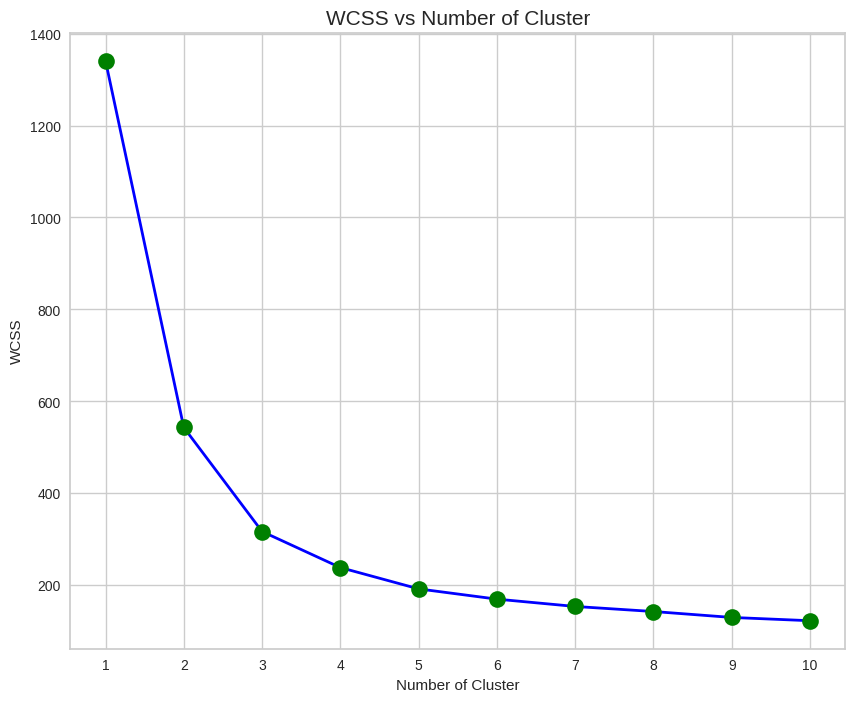

In [127]:
plt.figure(figsize=(10,8))
plt.plot(list(range(1,11)), wcss, color = 'blue', marker = 'o', linewidth=2, markersize=12, markerfacecolor= 'green',
         markeredgecolor= 'green')
plt.title('WCSS vs Number of Cluster', fontsize = 15)
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.xticks(list(range(1,11)))
plt.show()

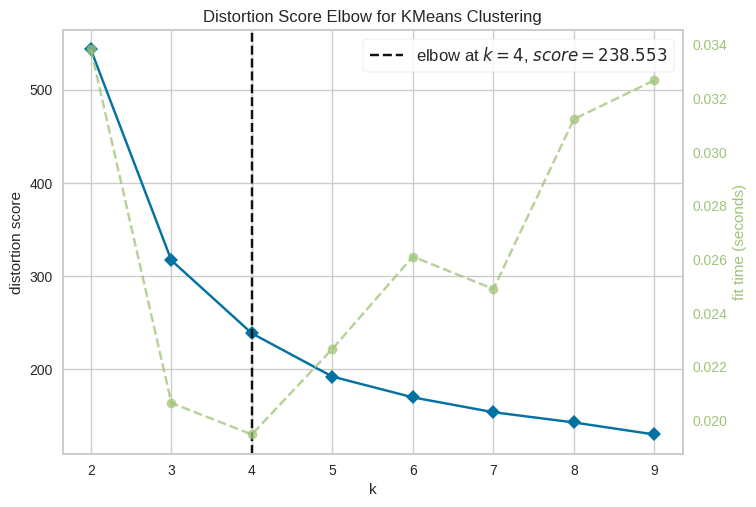

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [128]:
from yellowbrick.cluster.elbow import KElbowVisualizer

#Elbow Method with yellowbrick library
visualizer = KElbowVisualizer(kmeanModel, k=(2,10))
visualizer.fit(X_std)
visualizer.show()

<Axes: >

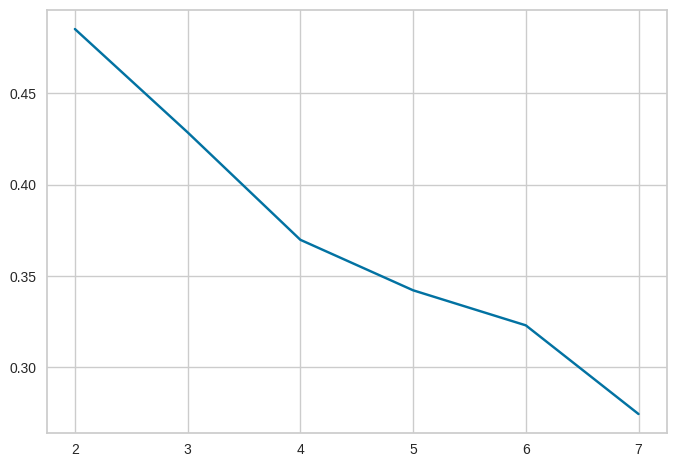

In [129]:
# Method 2 : Silhoutte Score

K = range(2,8)
fits=[]
score=[]

for k in K:
    modelsilhoutte = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(scaled_data)
    fits.append(modelsilhoutte)
    score.append(silhouette_score(scaled_data, modelsilhoutte.labels_, metric='euclidean'))

sns.lineplot(x = K, y = score)

In [130]:
# Kmeans n_cluster = 4
#Clustering Kmeans
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=100)
kmeans_4.fit(scaled_data)

KMeans(n_clusters=4, n_init=10, random_state=100)

In [131]:
# Masukin cluster ke dataset
df_clustering['cluster'] = kmeans_4.labels_
df_clustering.head()

,TransactionID,Qty,TotalAmount,cluster,CustomerID
0,17,60,623300,3,1
1,13,57,392300,1,2
2,15,56,446200,1,3
3,10,46,302500,0,4
4,7,27,268600,2,5


<Figure size 600x600 with 0 Axes>

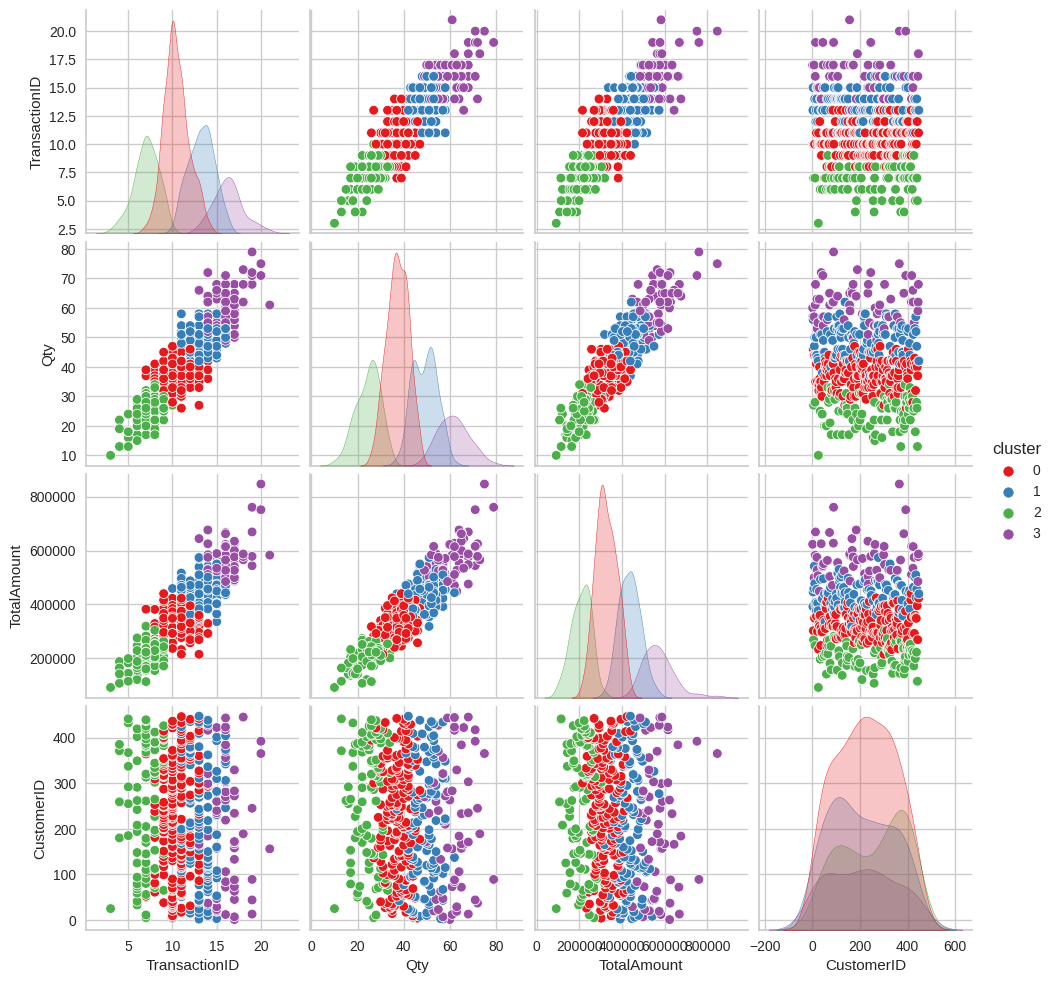

In [135]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_clustering,hue='cluster',palette='Set1')
plt.show()

In [133]:
df_clustering['CustomerID'] = df_precluster['CustomerID']
df_clustering_mean = df_clustering.groupby('cluster').agg({'CustomerID':'count','TransactionID':'mean','Qty':'mean','TotalAmount':'mean'})
df_clustering_mean.sort_values('CustomerID', ascending = False)

,CustomerID,TransactionID,Qty,TotalAmount
cluster,,,,
0,180,10.427778,37.350000,325663.333333
1,114,13.254386,49.078947,436203.508772
2,93,7.021505,24.505376,208283.870968
3,60,16.316667,61.650000,572100.000000


In [60]:
df_clustering['Cluster'] = kmeans_model.labels_
df_clustering['CustomerID'] = temp
df_clustering

NameError: ignored

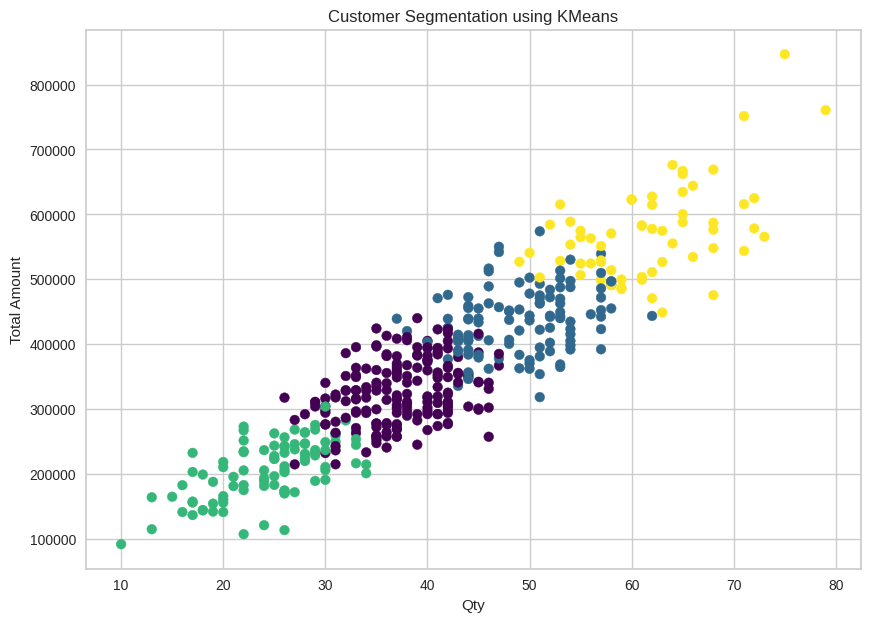

In [136]:
plt.figure(figsize = (10, 7))
plt.scatter(df_clustering['Qty'],
            df_clustering['TotalAmount'],
            c = df_clustering['cluster'],
           cmap = 'viridis')
plt.xlabel('Qty')
plt.ylabel('Total Amount')
plt.title('Customer Segmentation using KMeans')
plt.show()

In [137]:
pip install plotly

In [139]:
import plotly.express as px

fig = px.scatter_3d(df_clustering, x='Qty', y='TotalAmount', z='cluster',
                     color='cluster', symbol='cluster', opacity=0.7)

fig.update_layout(scene=dict(xaxis_title='Qty',
                             yaxis_title='Total Amount',
                             zaxis_title='cluster'),
                  title='Customer Segmentation using KMeans',
                  margin=dict(l=0, r=0, b=0, t=40))

fig.show()

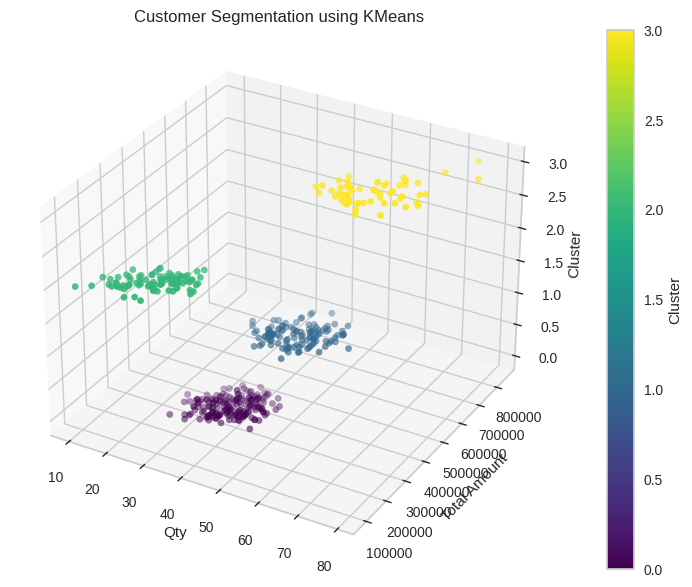

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_clustering['Qty'],
                      df_clustering['TotalAmount'],
                      df_clustering['cluster'],
                      c=df_clustering['cluster'], cmap='viridis')

ax.set_xlabel('Qty')
ax.set_ylabel('Total Amount')
ax.set_zlabel('Cluster')
ax.set_title('Customer Segmentation using KMeans')

colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster')

plt.show()

In [142]:
cluster_stats = df_clustering.groupby(['cluster']).agg({
    'CustomerID':'count',
    'TransactionID': ['mean', 'median'],
    'Qty': ['mean', 'median'],
    'TotalAmount': ['mean', 'median']
})
cluster_stats

CustomerID TransactionID               Qty           TotalAmount  \
             count          mean median       mean median           mean   
cluster                                                                    
0              180     10.427778   10.0  37.350000   37.0  325663.333333   
1              114     13.254386   13.0  49.078947   50.0  436203.508772   
2               93      7.021505    7.0  24.505376   25.0  208283.870968   
3               60     16.316667   16.0  61.650000   61.5  572100.000000   

                   
           median  
cluster            
0        319700.0  
1        438800.0  
2        211000.0  
3        565200.0

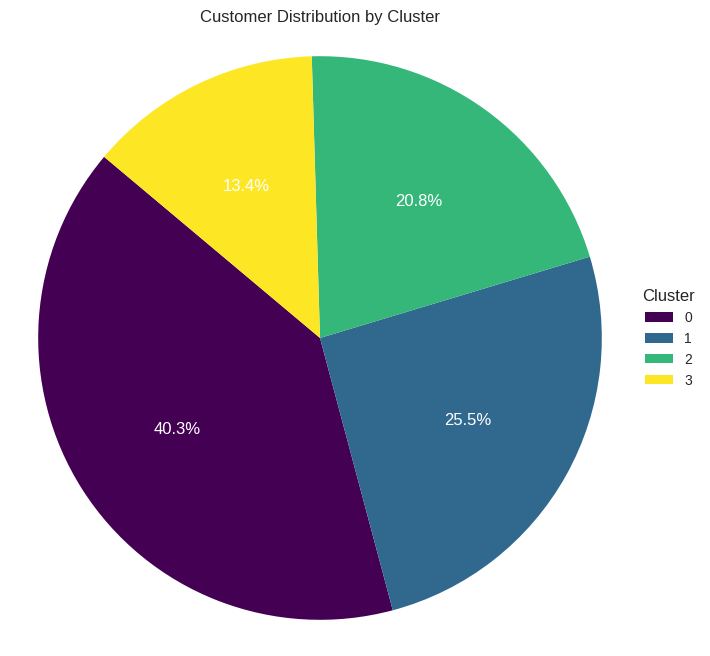

In [143]:
import matplotlib.cm as cm

n_clusters = cluster_stats['CustomerID']['count']
colors = cm.get_cmap('viridis', len(n_clusters))
pie_colors = colors(range(len(n_clusters)))
text_colors = ['white', 'black', 'white']

plt.figure(figsize=(8, 8))
plt.pie(n_clusters, labels=n_clusters.index, autopct='%1.1f%%',
        startangle=140, colors = pie_colors, textprops={'color': 'white'})
plt.title('Customer Distribution by Cluster')
plt.axis('equal')
plt.legend(n_clusters.index, title="Cluster", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()